In [1]:
import random
import matplotlib.pyplot as plt
import cv2

from detectron2.data import DatasetCatalog, MetadataCatalog, get_detection_dataset_dicts
from detectron2.utils.visualizer import Visualizer, ColorMode

from data_utils import read_split_file, register_dataset
%matplotlib inline

In [2]:
mixed_sets = read_split_file("data/missed_detections/mixed/split.txt")

# Register mixed datasets
for spl, im_paths in zip(["train", "val", "test"], mixed_sets):
    DatasetCatalog.register(
        f"{spl}", lambda im_paths=im_paths: register_dataset(im_paths)
    )
    MetadataCatalog.get(f"mixed_{spl}").set(
        thing_classes=["label", "button"],
        thing_colors=[(0, 255, 0), (0, 0, 255)],
    )

In [3]:
trainset = get_detection_dataset_dicts("train", filter_empty=False)
len(trainset)

registering mixed dataset: 100%|██████████| 3293/3293 [01:28<00:00, 37.06it/s] 


3293

In [ ]:
for d in trainset:
    print(d["file_name"])

data/missed_detections/mixed/mixed_46_21.jpg


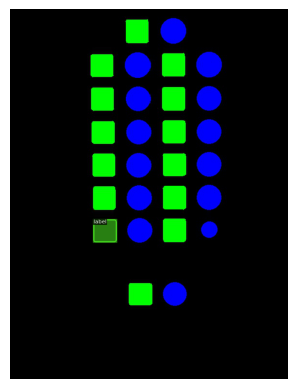

data/missed_detections/mixed/mixed_83_6.jpg


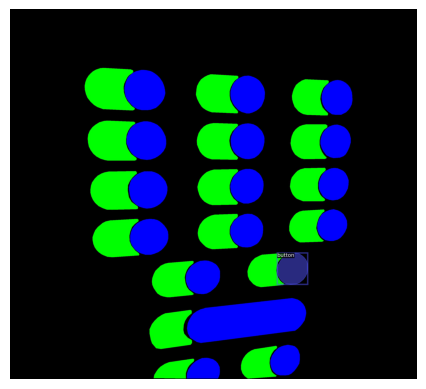

data/missed_detections/mixed/mixed_88_91.jpg


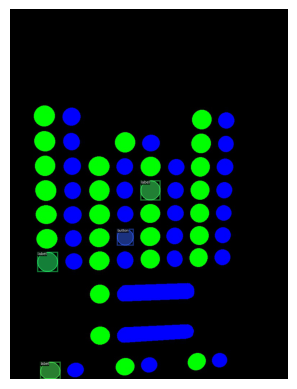

data/missed_detections/mixed/mixed_2_1.jpg


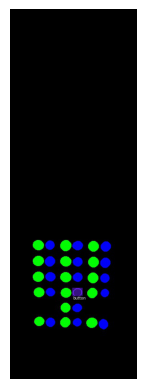

data/missed_detections/mixed/mixed_88_63.jpg


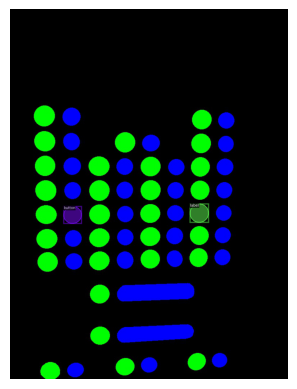

data/missed_detections/mixed/mixed_76_10.jpg


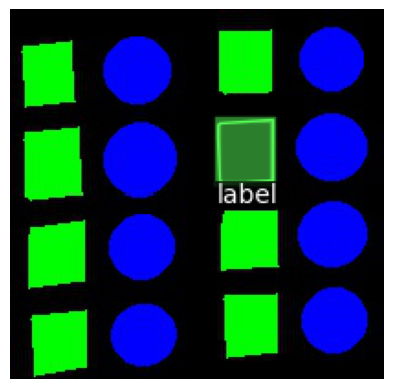

data/missed_detections/mixed/mixed_5_60.jpg


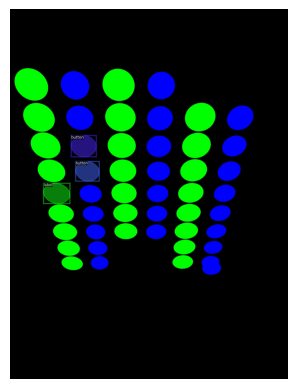

data/missed_detections/mixed/mixed_89_51.jpg


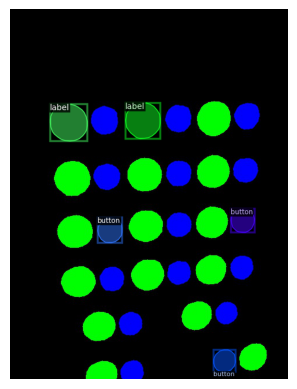

data/missed_detections/mixed/mixed_67_27.jpg


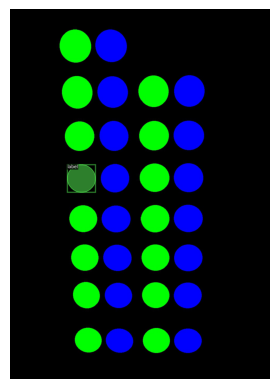

data/missed_detections/mixed/mixed_81_90.jpg


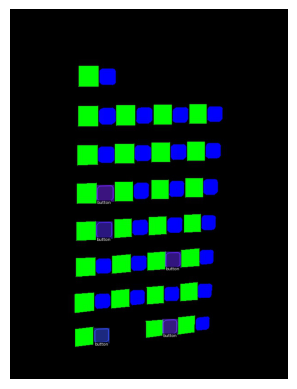

data/missed_detections/mixed/mixed_31_19.jpg


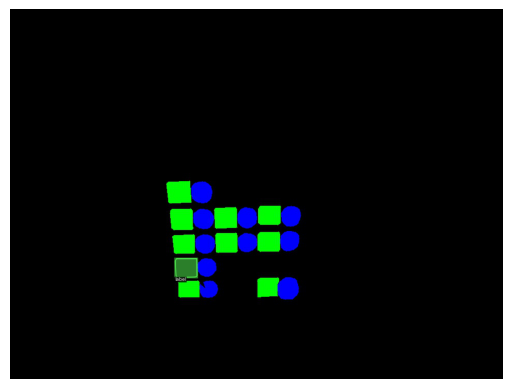

data/missed_detections/mixed/mixed_15_12.jpg


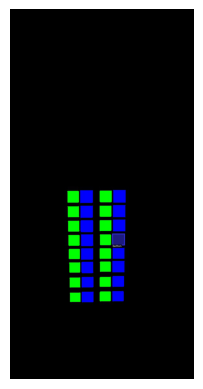

data/missed_detections/mixed/mixed_9_8.jpg


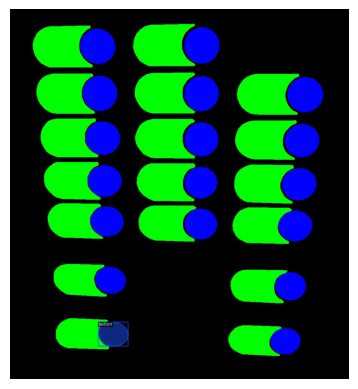

data/missed_detections/mixed/mixed_82_50.jpg


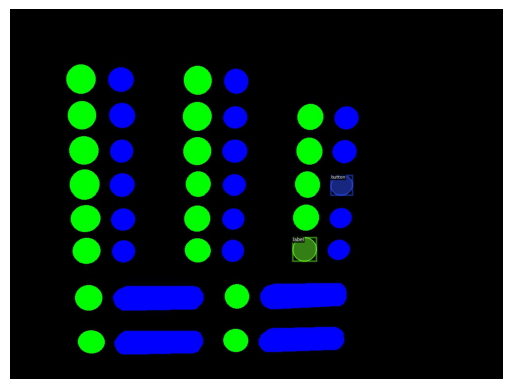

data/missed_detections/mixed/mixed_54_none.jpg


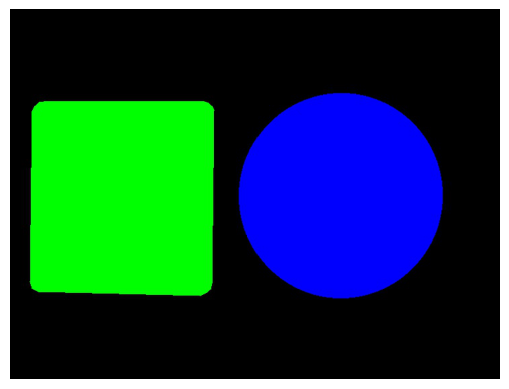

data/missed_detections/mixed/mixed_4_19.jpg


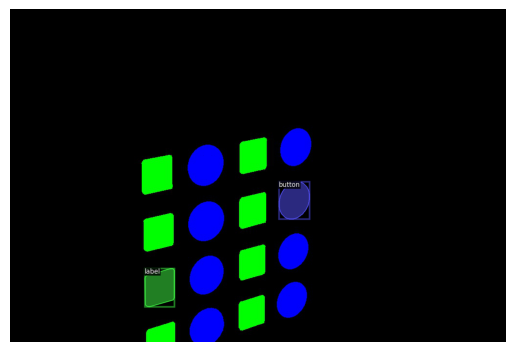

data/missed_detections/mixed/mixed_88_14.jpg


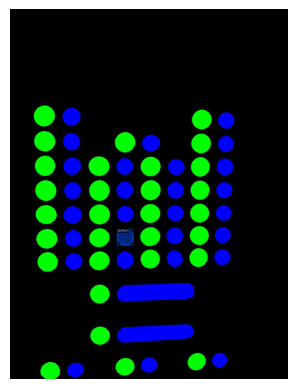

data/missed_detections/mixed/mixed_18_12.jpg


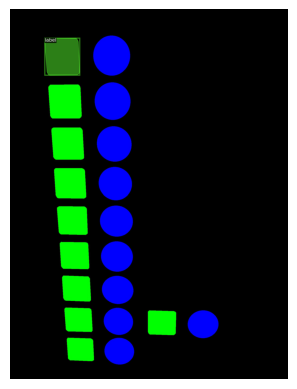

data/missed_detections/mixed/mixed_89_47.jpg


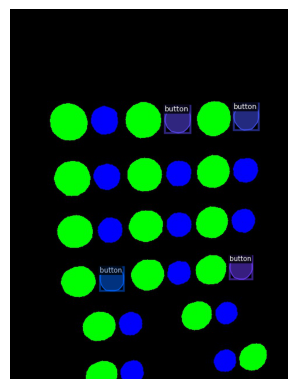

data/missed_detections/mixed/mixed_88_6.jpg


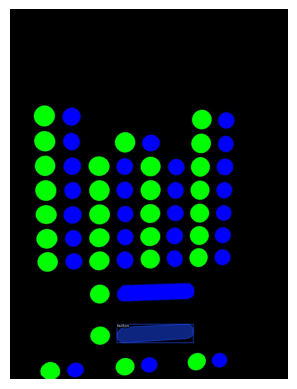

In [4]:
for d in random.sample(trainset, 20):
    print(d["file_name"])
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(
        img[:, :, ::-1],
        metadata=MetadataCatalog.get("mixed_train"),
        scale=1,
        instance_mode=ColorMode.SEGMENTATION,
    )
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image())
    plt.axis("off")
    plt.show()